In [165]:
%load_ext autoreload
%autoreload 2

import os
import json
from collections import Counter
import numpy as np
from parlai_internal.projects.seq2plan2seq.controlled_seq2seq.control_vars import CONTROL2NUMBUCKETS, CONTROL2CONTINUOUS
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [166]:
models_dirs = ['/private/home/abisee/models', '/tmp']
mf2wordstats = {}

for models_dir in models_dirs:
    wordstat_files = [fname for fname in os.listdir(models_dir) if 'wordstats.json' in fname]
    for json_file in wordstat_files:
        if "controlled_seq2seq" not in json_file and "goldresponse" not in json_file and "throwaway" not in json_file:
            continue
        mf = json_file[:json_file.index('.wordstats.json')]
        print(mf)
        with open(os.path.join(models_dir, json_file), "r") as f:
            data = json.load(f)
        mf2wordstats[mf] = data


goldresponse
throwaway.valid.beam1.beamminnbest30.setcontrols:contuserwordNone_niwf_10bucketsNone_questionNone


In [167]:
from IPython.display import HTML, display
import tabulate

def mean(l):
    return sum(l)/len(l)

def model2row(mf, wordstats):
#     avg_niwf = wordstats['niwf']['avg_niwf']*100
    mean_wlength = mean(wordstats['word_statistics']['mean_wlength'])
    mean_clength = mean(wordstats['word_statistics']['mean_clength'])
    row = [
        mf,
        wordstats['report']['exs'],
        wordstats['report']['ppl'],
        "%.2f%%" % wordstats['unique_percent'],
        "%.2f" % mean_wlength,
        "%.2f" % mean_clength,
#         "%.4f%%" % avg_niwf,
        "%i" % wordstats['word_statistics']['freqs_cnt']['100'],
        "%i" % wordstats['word_statistics']['freqs_cnt']['1000'],
        "%i" % wordstats['word_statistics']['freqs_cnt']['10000'],
#         "%.4f" % wordstats['distinct-n']['1'],
#         "%.4f" % wordstats['distinct-n']['2'],
#         "%.4f" % wordstats['distinct-n']['3'],
#         "%.4f" % wordstats['distinct-n']['4'],
    ]
    
    for control, num_buckets in CONTROL2NUMBUCKETS.items():
        conf_matrix = np.array(wordstats['faithfulness_stats']['confusion_matrices'][control])
        for b in range(num_buckets):
            acc = conf_matrix[b, b] / np.sum(conf_matrix[b, :])
            row.append("%.2f%%" % (acc*100))
        
    return row

header_row = ['model name', 
              'num_exs', 
              'ppl',
              'unique_perc', 
              'mean_wlength', 
              'mean_clength', 
#               'avg_niwf',
              '# rare<100', 
              '# rare<1000', 
              '# rare<10000',
#               'distinct-1',
#               'distinct-2',
#               'distinct-3',
#               'distinct-4',
             ] 

for control, num_buckets in CONTROL2NUMBUCKETS.items():
    for b in range(num_buckets):
        header_row.append('%s bucket %i acc' % (control, b))

table = [header_row] 

for mf in sorted(mf2wordstats.keys()):
    table.append(model2row(mf, mf2wordstats[mf]))
    
display(HTML(tabulate.tabulate(table, tablefmt='html')))

model name,num_exs,ppl,unique_perc,mean_wlength,mean_clength,# rare<100,# rare<1000,# rare<10000,question bucket 0 acc,question bucket 1 acc,niwf_10buckets bucket 0 acc,niwf_10buckets bucket 1 acc,niwf_10buckets bucket 2 acc,niwf_10buckets bucket 3 acc,niwf_10buckets bucket 4 acc,niwf_10buckets bucket 5 acc,niwf_10buckets bucket 6 acc,niwf_10buckets bucket 7 acc,niwf_10buckets bucket 8 acc,niwf_10buckets bucket 9 acc,contuserword bucket 0 acc,contuserword bucket 1 acc
goldresponse,7801,24.97,98.77%,11.87,51.22,630,3636,11218,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%
throwaway.valid.beam1.beamminnbest30.setcontrols:contuserwordNone_niwf_10bucketsNone_questionNone,7801,24.97,74.45%,11.88,44.18,182,1924,9038,97.82%,64.89%,52.36%,21.40%,17.67%,14.76%,12.07%,10.15%,5.15%,5.35%,4.42%,0.67%,75.46%,41.63%


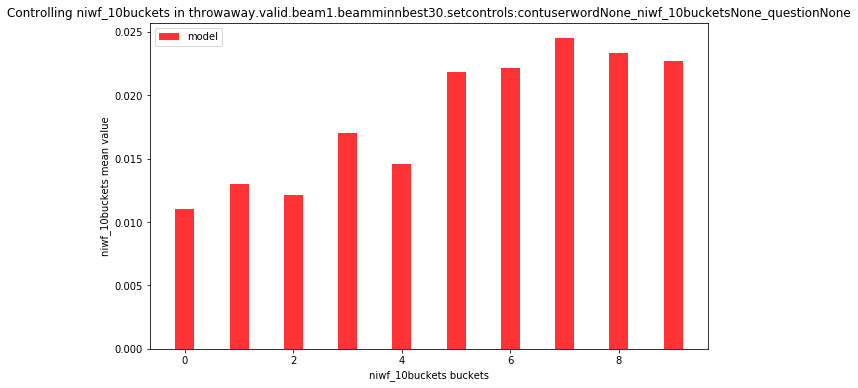

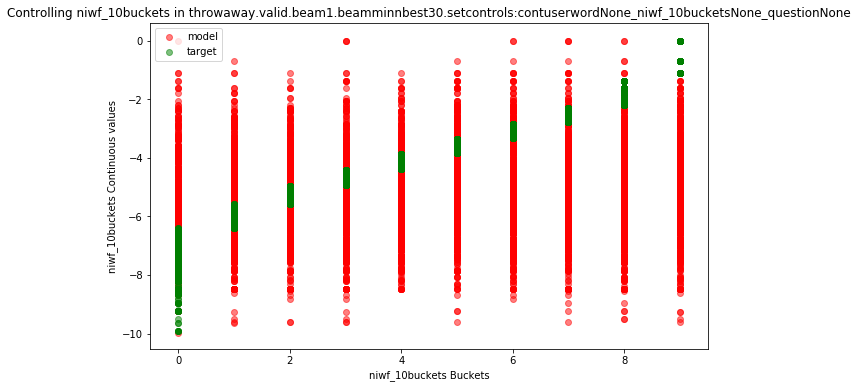

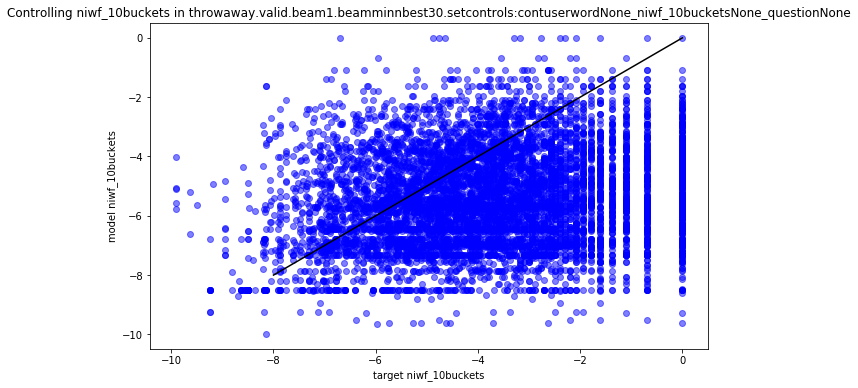

In [185]:
# plot distribution of continuous control vars

for mf in sorted(mf2wordstats.keys()):
    if mf=='goldresponse':
        continue
    wordstats = mf2wordstats[mf]

    for control, num_buckets in CONTROL2NUMBUCKETS.items():
        if not CONTROL2CONTINUOUS[control]:
            continue
        
        # these are both dicts from bucketid to list of floats
        cont_vals_model = wordstats['faithfulness_stats']['continuous_values'][control]['model']
        cont_vals_target = wordstats['faithfulness_stats']['continuous_values'][control]['target']
        cont_vals_model = {int(k):v for k,v in cont_vals_model.items()}
        cont_vals_target = {int(k):v for k,v in cont_vals_target.items()}
        
        num_buckets = CONTROL2NUMBUCKETS[control]
        
        # BUCKET BAR CHART
        figure(figsize=(10, 6))
#         y_model = [-1/mean(np.log(cont_vals_model[b])) for b in range(num_buckets)]
        y_model = [mean(cont_vals_model[b]) for b in range(num_buckets)]
        y_target = [-1/mean(np.log(cont_vals_target[b])) for b in range(num_buckets)]
        x = np.array([b for b in range(num_buckets)])
        bar_width = 0.35
        opacity = 0.8
        rects1 = plt.bar(x, y_model, bar_width,
                         alpha=opacity,
                         color='r',
                         label='model')
#         rects2 = plt.bar(x + bar_width, y_target, bar_width,
#                          alpha=opacity,
#                          color='g',
#                          label='target')
        plt.xlabel("%s buckets" % control)
        plt.ylabel("%s mean value" % control)
        plt.title("Controlling %s in %s" % (control, mf))
        plt.legend(loc='upper left')
        plt.show()
        

        # BUCKET SCATTER PLOT
        x = []
        for b in range(num_buckets):
            assert len(cont_vals_model[b]) == len(cont_vals_target[b])
            x += [b] * len(cont_vals_model[b])
            
        y_model = []
        for b in range(num_buckets):
            y_model += cont_vals_model[b]
        y_model = np.log(y_model)
            
        y_target = []
        for b in range(num_buckets):
            y_target += cont_vals_target[b]
        y_target = np.log(y_target)
        figure(figsize=(10, 6))
        plt.scatter(x, y_model, c="r", alpha=0.5, label="model")
        plt.scatter(x, y_target, c="g", alpha=0.5, label="target")
        plt.xlabel("%s Buckets" % control)
        plt.ylabel("%s Continuous values" % control)
        plt.title("Controlling %s in %s" % (control, mf))
        plt.legend(loc='upper left')
        plt.show()
        
        x = []
        y = []
        for b in range(num_buckets):
            x += cont_vals_target[b]
            y += cont_vals_model[b]
        x = np.log(x)
        y = np.log(y)
            
            
        # CONTINUOUS SCATTER PLOT
        figure(figsize=(10, 6))
        plt.scatter(x, y, c="b", alpha=0.5)
        plt.xlabel("target %s" % control)
        plt.ylabel("model %s" % control)
        plt.title("Controlling %s in %s" % (control, mf))
        plt.plot([-8, 0], [-8, 0], 'k-')
        plt.show()

In [99]:
print(mf2wordstats['goldresponse'].keys())
print(mf2wordstats['throwaway.valid.beam1.beamminnbest3.setcontrols:contuserwordNone_niwf_10bucketsNone_questionNone']['faithfulness_stats'].keys())


dict_keys(['opt', 'unique_percent', 'word_statistics', 'predictions', 'report', 'faithfulness_stats'])
dict_keys(['contuserword', 'niwf_10buckets', 'question'])


In [4]:
def show_preds(mf):
    counter = Counter()
    preds = mf2wordstats[mf]['predictions']
    counter.update(preds)
    num_unique = len([p for p,count in counter.items() if count==1])
    print("num_unique: ", num_unique, num_unique*100/sum(counter.values()))
#     for p, count in counter.most_common(100):
#         print("%3i   %s" % (count, p))

In [5]:
show_preds('convai2_pretrain.valid.beam20')

num_unique:  586 7.511857454172542


In [6]:
show_preds('seq2seq_twitterpretrained_specificityclusters_10buckets.valid.beam20.fixed_clusterid9')

num_unique:  1983 25.419817972054865
